# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import math
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.style.use('ggplot')

# Load Dataset

In [2]:
df = pd.read_csv("EW-MAX.csv")  
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## Preview the dataset

In [4]:
print("Dataset Head:")
display(df.head())

Dataset Head:


,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


## Check for missing values

In [5]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


##  Basic statistics

In [6]:
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,Open,High,Low,Close,Adj_Close,Volume
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4.392000e+03
mean,30.562539,30.893618,30.238833,30.572580,30.572580,1.884027e+06
std,29.914758,30.210974,29.615761,29.905778,29.905778,1.621609e+06
min,3.296875,3.390625,3.000000,3.250000,3.250000,1.904000e+05
25%,8.718125,8.803125,8.625000,8.712500,8.712500,1.088800e+06
50%,14.766250,14.981250,14.662500,14.767500,14.767500,1.539300e+06
75%,42.546248,43.051249,42.086249,42.539999,42.539999,2.188900e+06
max,121.080002,121.750000,120.169998,121.360001,121.360001,4.641260e+07


# Visualize Close Price

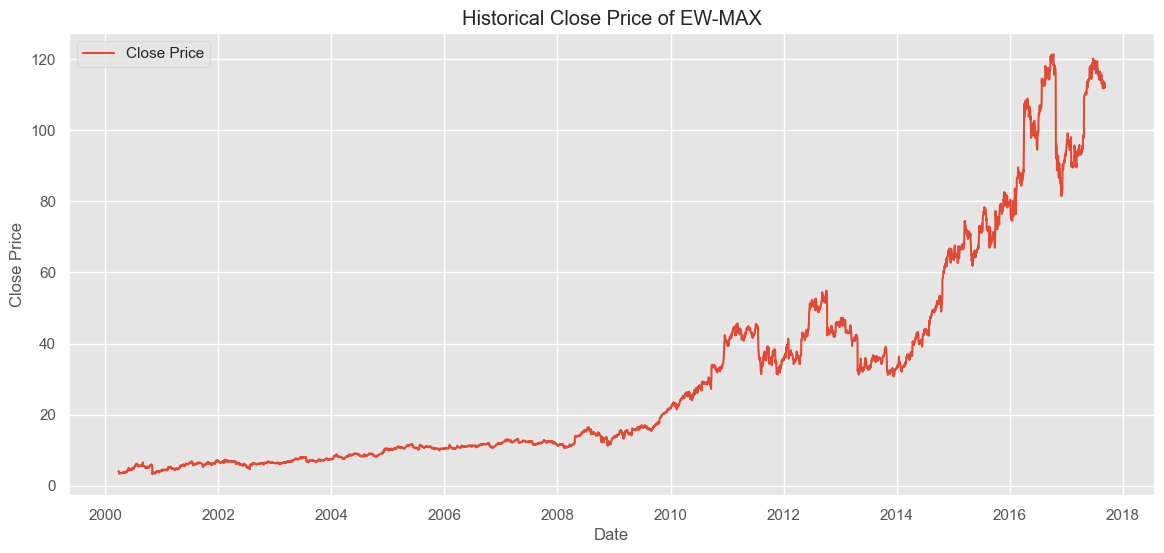

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title("Historical Close Price of EW-MAX")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


# Data Preprocessing

### Use only 'Close' prices

In [8]:
data = df.filter(['Close']).values

### Normalize prices to [0, 1]

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### Define training size (80%)

In [10]:
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

### Split data into train and test

In [11]:
train_data = scaled_data[0:training_data_len]
test_data = scaled_data[training_data_len - 60:] 

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (3514, 1)
Testing data shape: (938, 1)


# Create Sequences for LSTM

In [12]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training sequences

In [13]:
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape inputs to [samples, time steps, features]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3454, 60, 1)
X_test shape: (878, 60, 1)


# Build the LSTM Model


In [16]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer for prediction

In [17]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 6.9265e-04 - val_loss: 4.4413e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 1.8283e-04 - val_loss: 1.9399e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.6027e-04 - val_loss: 1.7976e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 1.1626e-04 - val_loss: 8.8662e-04
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.5965e-04 - val_loss: 7.9711e-04
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.1709e-04 - val_loss: 3.2684e-04
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.1473e-04 - val_loss: 1.7434e-04
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.1698e-04 - val_loss: 3.8777e-04
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.2647e-04 - val_loss: 1.3114e-04
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.0405e-04 - val_loss: 2.0883e-04
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.0016e-

# Visualize Loss During Training

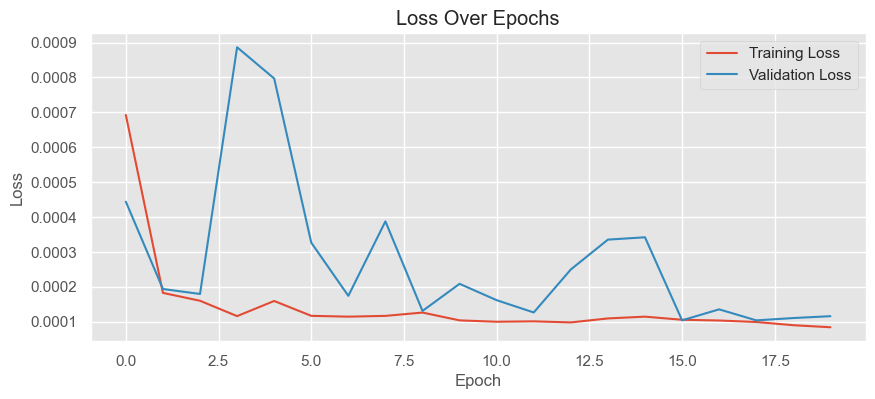

In [20]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Predict on Test Data

In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [24]:
# Inverse scale actual values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Predictions vs Actual

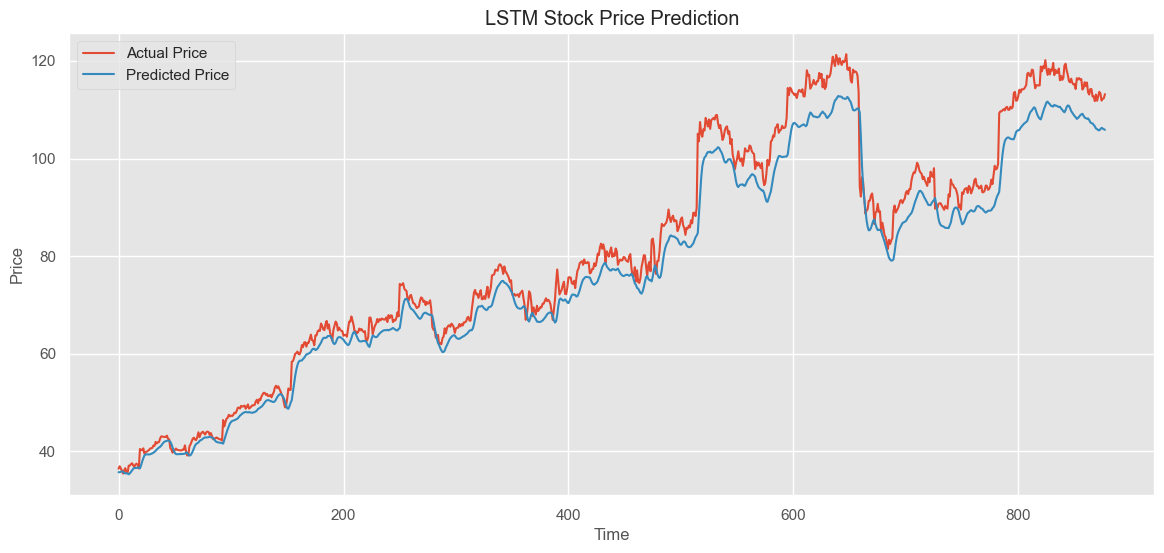

In [25]:
plt.figure(figsize=(14,6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluation - RMSE

In [26]:
rmse = math.sqrt(mean_squared_error(actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 4.8144


In [27]:
print(df['Close'].min(), df['Close'].max(), df['Close'].mean())


3.25 121.360001 30.57258004553734


In [28]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

mape = mean_absolute_percentage_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"MAPE: {mape:.2%}")
print(f"R² Score: {r2:.4f}")


MAPE: 4.55%
R² Score: 0.9598
